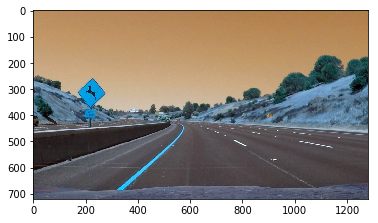

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
%matplotlib inline

img = cv2.imread('test_images/test2.jpg')
#calibrated = cv2.undistort(img, mtx, dist, None, mtx)
plt.imshow(img)
 

In [2]:
class Line():
    def __init__(self):
        self.N = 10
        self.detected_q = False  # line detected in last frame
        self.xfit_q = []         # previous fit points
        self.avgx = None         # average x values in previous fits
        self.poly = np.zeros((self.N, 3))   # average polynomial coeffs
        self.poly_idx = 0
        self.fit_q = [np.array([False])]
        self.radius = np.zeros((1,self.N))  # last N radius values (circular buffer)
        self.radius_idx = 0
        self.diffs = np.array([0,0,0], dtype='float')  # difference in fit coeffs
        self.allx = None  # line pixel x values
        self.ally = None  # line pixel y values
    def push_poly(self, poly):
        self.poly[self.poly_idx, :] = poly
        self.poly_idx = (self.poly_idx + 1) % self.N
    def get_avg_poly(self):
        n = len(np.nonzero(self.poly[:,0])[0])
        if n > 0:
            return np.sum(self.poly, axis=0) / n
        return 0
    def fit_avg_poly(self):
        ploty = np.linspace(0, 719, 720)
        fit = self.get_avg_poly()
        fitx = fit[0]*ploty**2 + fit[1]*ploty + fit[2]
        return fitx, ploty
    def push_radius(self, r):
        self.radius[0, self.radius_idx] = r
        self.radius_idx = (self.radius_idx + 1) % self.N
    def get_avg_radius(self):
        n = len(np.nonzero(self.radius)[0])
        if n > 0:
            return np.sum(self.radius) / n
        return 0
        


In [3]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [18]:
# Camera calibration
def calibrate():
    nx = 9  # corners on chessboard
    ny = 6

    fnames = glob.glob('camera_cal/calibration*.jpg')

    # object points; prepare as in lecture
    objp = np.zeros((nx * ny, 3), np.float32)
    # -- note [:,:2] means [:,0:2]
    # -- note T means transpose
    # -- note reshape is from (6, 9, 2), transposed, to (54, 2)
    objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1, 2)  # x,y coordinates

    img_points = []
    obj_points = []
    for fname in fnames:
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
        if ret == True:
            img_points.append(corners)
            obj_points.append(objp)
            #cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(obj_points, img_points, img.shape[0:2], None, None)
    return mtx, dist



def frame_to_binary(calibrated):
    # Image Thresholding
    # -- compute Sobel gradients
    # -- select the Saturation component in HLS color space
    # -- apply AND'd threshold mixing gradient and S
    # ---- gradient filters for vertical orientation
    # ---- S has superior lighting invariance vs grayscale threshold per lecture

    hls = cv2.cvtColor(calibrated, cv2.COLOR_BGR2HLS)
    S = hls[:,:,2]
    hls_thresh = [125, 255]
    s_binary = np.zeros_like(S)
    s_binary[(S >= hls_thresh[0]) & (S <= hls_thresh[1])] = 1

    gray = cv2.cvtColor(calibrated, cv2.COLOR_BGR2GRAY)
    sobel_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=15)
    sobel_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=15)
    abs_sobel_x = np.absolute(sobel_x)
    abs_sobel_y = np.absolute(sobel_y)
    arc = np.arctan2(abs_sobel_y, abs_sobel_x)
    arc_scaled = np.uint8(255*arc/np.max(arc))
    dir_thresh = [0.9, 1.1]
    dir_binary = np.zeros_like(arc)
    dir_binary[(arc >= dir_thresh[0]) & (arc <= dir_thresh[1])] = 1

    sobel_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=5)
    abs_sobel_y = np.absolute(sobel_y)
    scaled_sobel = np.uint8(255 * abs_sobel_y / np.max(abs_sobel_y))
    sobel_thresh = [100, 255]
    sy_binary = np.zeros_like(arc)
    sy_binary[(scaled_sobel >= sobel_thresh[0]) & (scaled_sobel <= sobel_thresh[1])] = 1

    binary = np.zeros_like(S)
    binary[(s_binary == 1) | ((sy_binary == 1) & (dir_binary == 1))] = 1
    #color_binary = np.dstack((binary, s_binary, np.zeros_like(dir_binary)))
    return binary



def get_warp():
    # Perspective Transform
    # -- Transform the image to create an overhead-view perspective

    src_pts = np.float32([[320,648], [1000,648], [805,525], [488,525]])
    dst_pts = np.float32([[320,648], [1000,648], [1000,525], [320,525]])

    M = cv2.getPerspectiveTransform(src_pts, dst_pts)
    Minv = cv2.getPerspectiveTransform(dst_pts, src_pts)
    return M, Minv



In [5]:
def find_lines(warped, left_line, right_line):
    # Find Lane Lines
    # -- Method from lectures
    # -- Start with a histogram of binary points to locate left and right peak columns; these should be the lane lines

    #out_img = np.dstack((warped, warped, warped)) * 255  # color image with white lines for binary input image

    vwindows = 9  # vertical windows in which to locate the horizontal line center
    vpix = warped.shape[0] / vwindows  # vertical search window
    hpix = 100                         # horizontal search window (one side)
    adj_thresh = 50  # pixels to trigger center position update
    left_inds = []     # left line accepted nonzero pixels
    right_inds = []    # right line accepted nonzero pixels

    # nonzero creates a pair of arrays containing the y and x indices of nonzero points
    nonzero = warped.nonzero()
    nonzeroy = nonzero[0]
    nonzerox = nonzero[1]

    if left_line.detected_q == False or right_line.detected_q == False:
        histogram = np.sum(warped[np.int(warped.shape[0]/2):,:], axis=0)  # bottom half of frame
        middle = np.int(histogram.shape[0]/2)  # handle the left side of the lane and the right side of the lane separately
        if left_line.detected_q == False:
            left_peak = np.argmax(histogram[:middle])
            leftx = left_peak  # moving horizontal center of search window, starting from histogram peak
        if right_line.detected_q == False:
            right_peak = middle + np.argmax(histogram[middle:])
            rightx = right_peak # moving horizontal center of search window, starting from histogram peak

        for w in range(vwindows):
            # since y is inverted, the range is [vtop:vbottom] non-inclusive
            vbottom = np.int(warped.shape[0] - (w * vpix))
            vtop = np.int(warped.shape[0] - ((w+1) * vpix))

            if left_line.detected_q == False:
                # left line
                hleft = np.int(leftx - hpix)
                hright = np.int(leftx + hpix)
                #cv2.rectangle(out_img, (hleft, vbottom), (hright, vtop), (0, 255, 0), 2)
                accepted_inds = ((nonzeroy >= vtop) & (nonzeroy < vbottom) & (nonzerox >= hleft) & (nonzerox < hright)).nonzero()[0]
                left_inds.append(accepted_inds)
                nz_pix = len(accepted_inds)
                if nz_pix >= adj_thresh:
                    # adjust the horizonal center
                    leftx = np.int(np.mean(nonzerox[accepted_inds]))

            if right_line.detected_q == False:
                # right line
                hleft = np.int(rightx - hpix)
                hright = np.int(rightx + hpix)
                #cv2.rectangle(out_img, (hleft, vbottom), (hright, vtop), (0, 255, 0), 2)
                accepted_inds = ((nonzeroy >= vtop) & (nonzeroy < vbottom) & (nonzerox >= hleft) & (nonzerox < hright)).nonzero()[0]
                right_inds.append(accepted_inds)
                nz_pix = len(accepted_inds)
                if nz_pix >= adj_thresh:
                    # adjust the horizontal center
                    rightx =np.int(np.mean(nonzerox[accepted_inds]))

    if left_line.detected_q == True:
        # search around previous line
        left_fit = left_line.current_fit  # current is still last frame
        accepted_inds = ((nonzerox >= (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - hpix)) &
                         (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + hpix)))
        # sanity check the pixels to make sure something like a line has been detected
        if len(accepted_inds) > 250:
            ymin = np.min(nonzeroy[accepted_inds])
            ymax = np.max(nonzeroy[accepted_inds])
            if (ymax - ymin) > 100:
                left_inds.append(accepted_inds)

    if right_line.detected_q == True:
        # search around previous line
        right_fit = right_line.current_fit  # current is still last frame
        accepted_inds = ((nonzerox >= (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - hpix)) &
                         (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + hpix)))
        # sanity check the pixels to make sure something like a line has been detected
        if len(accepted_inds) > 250:
            ymin = np.min(nonzeroy[accepted_inds])
            ymax = np.max(nonzeroy[accepted_inds])
            if (ymax - ymin) > 100:
                right_inds.append(accepted_inds)
        
    ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0])
    y_eval = np.max(ploty)
    ym_per_pix = 30/720  # meters per pixel in y direction (30 m range of frame)
    xm_per_pix = 3.7/700 # meters per pixel in x direction (3.7 m std lane width)
    if len(left_inds) > 0:
        left_inds = np.concatenate(left_inds)
        leftx = nonzerox[left_inds]
        lefty = nonzeroy[left_inds]
        # fit a polynomial to the points selected above
        left_fit = np.polyfit(lefty, leftx, 2)
        # use the polynomial to generate x for linspace y values
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        left_line.allx = leftx
        left_line.ally = lefty
        left_line.current_fit = left_fit
        left_line.xfit_q = left_fitx
        # compute radius using new polynomial scaled from pixels to meters
        left_fit = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
        left_line.radius_of_curvature = ((1 + (2*left_fit[0]*y_eval*ym_per_pix + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
        left_line.detected_q = True
    else:
        left_line.detected_q = False

    if len(right_inds) > 0:
        right_inds = np.concatenate(right_inds)
        rightx = nonzerox[right_inds]
        righty = nonzeroy[right_inds]
        # fit a polynomial to the points selected above
        right_fit = np.polyfit(righty, rightx, 2)
        # use the polynomial to generate x for linspace y values
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
        right_line.allx = rightx
        right_line.ally = righty
        right_line.current_fit = right_fit
        right_line.xfit_q = right_fitx
        # compute radius using new polynomial scaled from pixels to meters
        right_fit = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
        right_line.radius_of_curvature = ((1 + (2*right_fit[0]*y_eval*ym_per_pix + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
        right_line.detected_q = True
    else:
        right_line.detected_q = False

    return



In [6]:
mtx, dist = calibrate()
left_line = Line()
right_line = Line()
M, Minv = get_warp()

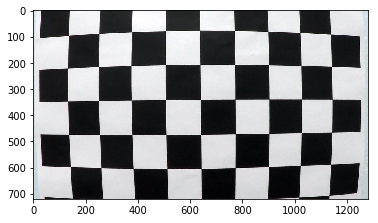

In [7]:
img = cv2.imread('camera_cal/calibration1.jpg')
calibrated = cv2.undistort(img, mtx, dist, None, mtx)
plt.imshow(img)

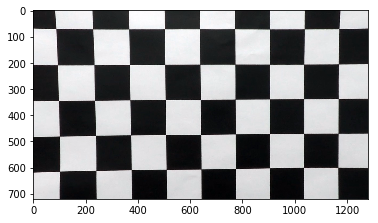

In [8]:
plt.imshow(calibrated)

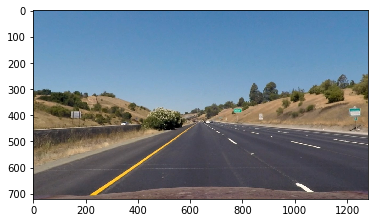

In [9]:
img = cv2.imread('test_images/straight_lines1.jpg')
calibrated = cv2.undistort(img, mtx, dist, None, mtx)
binary = frame_to_binary(calibrated)
plt.imshow(cv2.cvtColor(calibrated, cv2.COLOR_BGR2RGB))

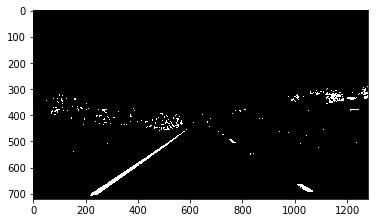

In [10]:
plt.imshow(binary, cmap='gray')

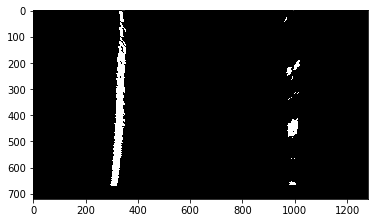

In [11]:
warped = cv2.warpPerspective(binary, M, (img.shape[1], img.shape[0]), flags=cv2.INTER_LINEAR)
plt.imshow(warped, cmap='gray')

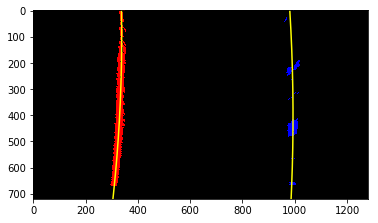

In [12]:
find_lines(warped, left_line, right_line)
lines_img = np.dstack((warped, warped, warped)) * 255
lines_img[left_line.ally, left_line.allx] = [255, 0, 0]
lines_img[right_line.ally, right_line.allx] = [0, 0, 255]
ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0])
plt.plot(left_line.xfit_q, ploty, color='yellow')
plt.plot(right_line.xfit_q, ploty, color='yellow')
plt.imshow(lines_img)

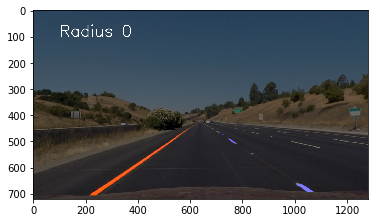

In [13]:
unwarped = cv2.warpPerspective(lines_img, Minv, (img.shape[1], img.shape[0]), flags=cv2.INTER_LINEAR)
result = cv2.addWeighted(cv2.cvtColor(calibrated, cv2.COLOR_BGR2RGB), 0.5, unwarped, 0.5, 0)
font = cv2.FONT_HERSHEY_SIMPLEX
ravg = 0.5 * (left_line.get_avg_radius() + right_line.get_avg_radius())
msg = 'Radius {:.0f}'.format(ravg)
cv2.putText(result, msg, (100,100), font, 2, (255,255,255), 2, cv2.LINE_AA)
plt.imshow(result)

In [14]:
def process_image(img):
    calibrated = cv2.undistort(img, mtx, dist, None, mtx)
    binary = frame_to_binary(calibrated)
    #warped = cv2.warpPerspective(calibrated, M, (img.shape[1], img.shape[0]), flags=cv2.INTER_LINEAR)
    #plt.imshow(warped, cmap='gray')
    warped = cv2.warpPerspective(binary, M, (img.shape[1], img.shape[0]), flags=cv2.INTER_LINEAR)
    find_lines(warped, left_line, right_line)

    window_img = np.dstack((warped, warped, warped)) * 255
    if left_line.detected_q == True and right_line.detected_q == True:
        ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0])
        left_line_window1 = np.array([np.transpose(np.vstack([left_line.xfit_q, ploty]))])
        right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_line.xfit_q, ploty])))])
        line_pts = np.hstack((left_line_window1, right_line_window2))
        cv2.fillPoly(window_img, np.int_([line_pts]), (0,255,0))
    if left_line.detected_q == True:
        window_img[left_line.ally, left_line.allx] = [255, 0, 0]
    if right_line.detected_q == True:
        window_img[right_line.ally, right_line.allx] = [0, 0, 255]

    unwarped = cv2.warpPerspective(window_img, Minv, (img.shape[1], img.shape[0]), flags=cv2.INTER_LINEAR)
    result = cv2.addWeighted(calibrated, 1.0, unwarped, 0.3, 0)
    font = cv2.FONT_HERSHEY_SIMPLEX
    ravg = 0.5 * (left_line.get_avg_radius() + right_line.get_avg_radius())
    msg = 'Radius {:.0f}'.format(ravg)
    cv2.putText(result, msg, (100,100), font, 2, (255,255,255), 2, cv2.LINE_AA)
    
    return result

In [17]:
project_output = 'project_post.mp4'
clip1 = VideoFileClip('project_video.mp4')
project_clip = clip1.fl_image(process_image)  # color images required
%time project_clip.write_videofile(project_output, audio=False)

[MoviePy] >>>> Building video project_post.mp4
[MoviePy] Writing video project_post.mp4


100%|█████████▉| 1260/1261 [04:17<00:00,  5.04it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_post.mp4 

CPU times: user 13min 33s, sys: 9.62 s, total: 13min 42s
Wall time: 4min 17s


In [16]:
HTML("""
<video width="1280" height="720" controls>
  <source src="{0}">
</video>
""".format(project_output))